In [31]:
import os
import pyro
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pyro.distributions as dist

from torch import Tensor
from torch import tensor
from tqdm.auto import trange
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive, config_enumerate
from pyro.distributions import constraints
from pyro.infer.autoguide import AutoDiagonalNormal

os.chdir("../../")

from src.dgp_rff.outer_layer import SingleGP

In [2]:
# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)
pyro.set_rng_seed(1)
random_state = np.random.RandomState(1)

# Read data
cwd = os.getcwd()

X_train_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_X_train.txt")
X_test_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_X_test.txt")
Y_train_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_Y_train.txt")
Y_test_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_Y_test.txt")

x_obs = np.loadtxt(X_train_path)
y_obs = np.loadtxt(Y_train_path)
x_val = np.loadtxt(X_test_path)
y_val = np.loadtxt(Y_test_path)

# Set plot limits and labels
xlims = [-0.2, 0.2]

# The X and Y have to be at least 2-dim
x_train = torch.from_numpy(x_obs).float().reshape(-1,1)
y_train = torch.from_numpy(y_obs).float()
x_test = torch.from_numpy(x_val).float().reshape(-1,1)
y_test = torch.from_numpy(y_val).float()

In [32]:
@config_enumerate
def train_model(X, in_dim, out_dim, N, batch_size, Y=None, J=50):
    model = SingleGP(
        in_dim=in_dim, 
        out_dim=out_dim, 
        J=J,
        num_layer=1,
        kernel_name='RBF',
    )
    
    scale = pyro.sample(
            "Global Sigma", 
            dist.Gamma(tensor(.5), tensor(1.)).expand([out_dim]).to_event(1)
        )
    
    mu = model.forward(X)

    with pyro.plate("Batch Data", size=N, subsample_size=batch_size):

        # Sampling model
        obs = pyro.sample(
            "Obs", 
            dist.Normal(mu, scale).to_event(1), 
            obs=Y,
        )

    return mu

In [4]:
model = train_model
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

batch_size = 1000
num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    idx = np.random.choice(y_train.shape[0], size=batch_size, replace=False)
    loss = svi.step(
        x_train[idx], 
        in_dim=x_train.shape[1],
        out_dim=y_train.shape[1],
        N=x_train.shape[0],
        batch_size=batch_size,
        Y=y_train[idx],
        J=50
    )
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/25000 [00:00<?, ?it/s]

In [5]:
def pred_model(X, in_dim, out_dim, N, batch_size, Y=None, J=50):
    model = SingleGP(
        in_dim=in_dim, 
        out_dim=out_dim, 
        J=J,
        num_layer=1,
        kernel_name='RBF',
    )
    
    scale = pyro.sample(
            "Global Sigma", 
            dist.Gamma(tensor(.5), tensor(1.)).expand([out_dim]).to_event(1)
        )
    
    mu = model.forward(X)

    with pyro.plate("Batch Data", size=N, subsample_size=X.shape[0]):

        # Sampling model
        obs = pyro.sample(
            "Obs", 
            dist.Normal(mu, scale).to_event(1), 
            obs=Y,
        )

    return mu

In [6]:
predictive = Predictive(train_model, guide=mean_field_guide, num_samples=500)
preds = predictive(
    x_train[idx],
    in_dim=x_test.shape[1],
    out_dim=y_test.shape[1],
    N=x_train.shape[0],
    batch_size=batch_size,
    J=50
)

In [7]:
y_pred = preds['Obs'].detach().numpy().mean(axis=0)

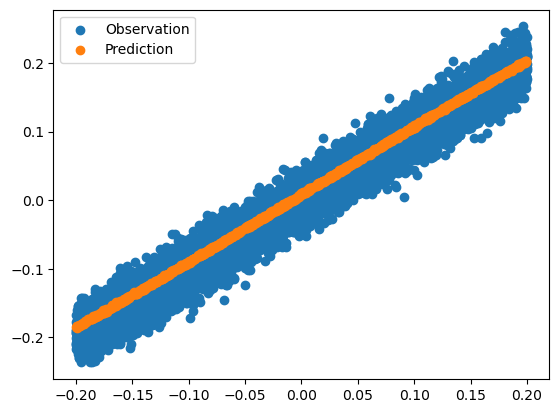

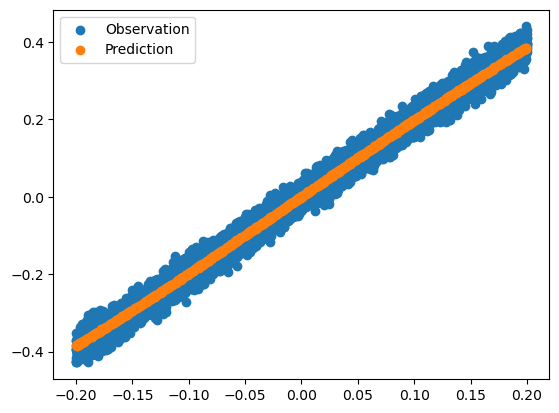

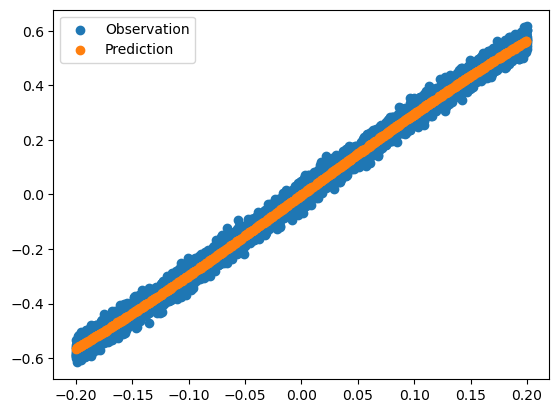

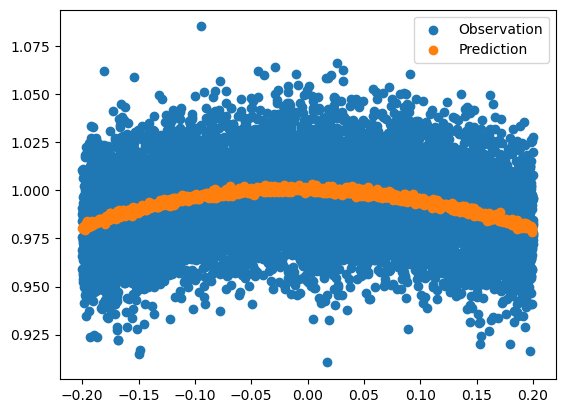

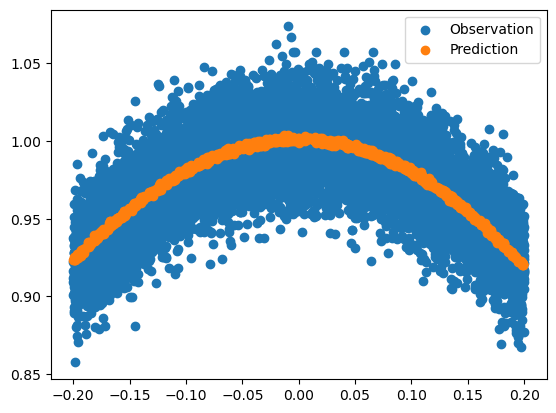

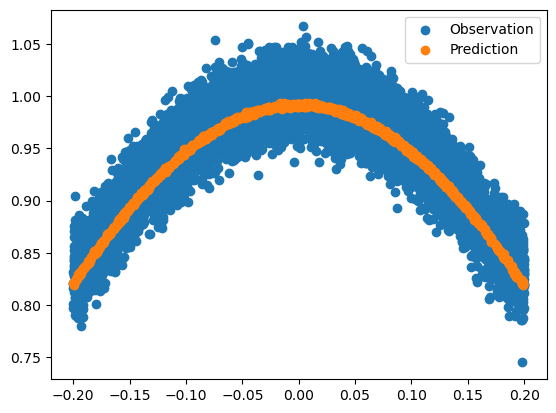

In [15]:
for d in range(6):
    plt.scatter(x_obs, y_obs[:,d], label="Observation")
    plt.scatter(x_train[idx], y_pred[:,d], label="Prediction")
    plt.legend()
    plt.show()

In [9]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

AutoDiagonalNormal.loc torch.Size([662])
AutoDiagonalNormal.scale torch.Size([662])
